# Demonstration of seismic event recognition using Semantic Segmentation Models

## Import Dependencies

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import tensor, cuda

### Add utils to sys to import our custom scripts
**Note:** This notebook should be run from the `examples` folder to ensure the correct imports and file paths are used.

In [ ]:
# Go up one level from 'examples' and point to 'utils' folder
utils_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'utils'))
# Add the 'utils' folder to sys.path
sys.path.append(utils_path)
models_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'models'))
# Add the 'models' folder to sys.path
sys.path.append(models_path)
import data_utils
from model_selector import model_selector

### Load the model

Model can be loaded through the model_selector() function. Available architectures are: "UNet", "UNetPlusPlus", "DeepLabV3", and "SwinUNet". N is set to 256, in future works we will possibly expand on this variable. If you wish to load the weights generated by the article, you can set the pretrained argument to True, it automatically downloads the weights from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.13902232.svg)](https://doi.org/10.5281/zenodo.13902232).

In [ ]:
device = "cuda" if cuda.is_available() == True else "cpu"
model = model_selector(arch='UNet', N=256, pretrained=True).to(device)

### Load and display example Data

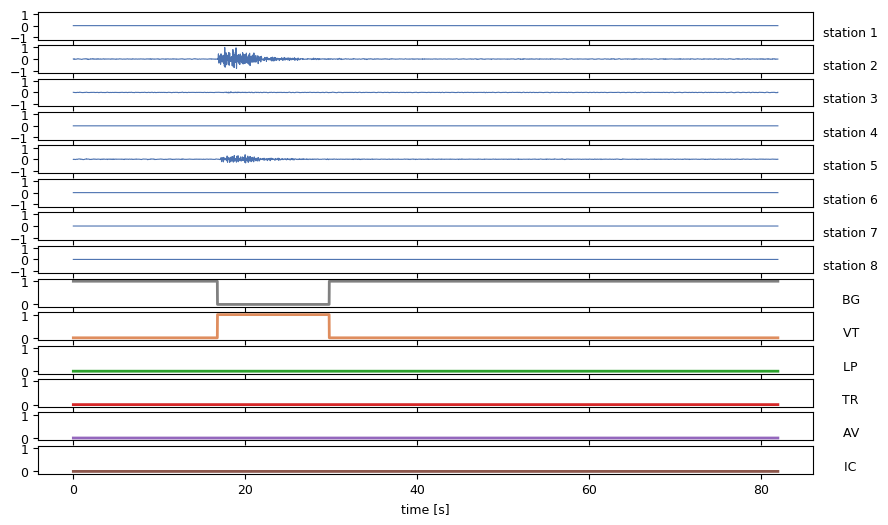

In [4]:
example_data = {"VT": "../data/example_VT.npy",
                 "LP": "../data/example_LP.npy",
                 "TR": "../data/example_TR.npy",
                 "AV": "../data/example_AV.npy",
                 "IC": "../data/example_IC.npy",
                 }
example_trace = np.load(example_data['VT'])
data_utils.plot_trace(example_trace,
                        n_stations=8,
                        save_path=None,
                        save=False,
                        title="",
                        num=0,
                        dpi=100,
                        figsize=(10, 6),
                        font_size=9)

...and the desired outputs:

(6, 8192)


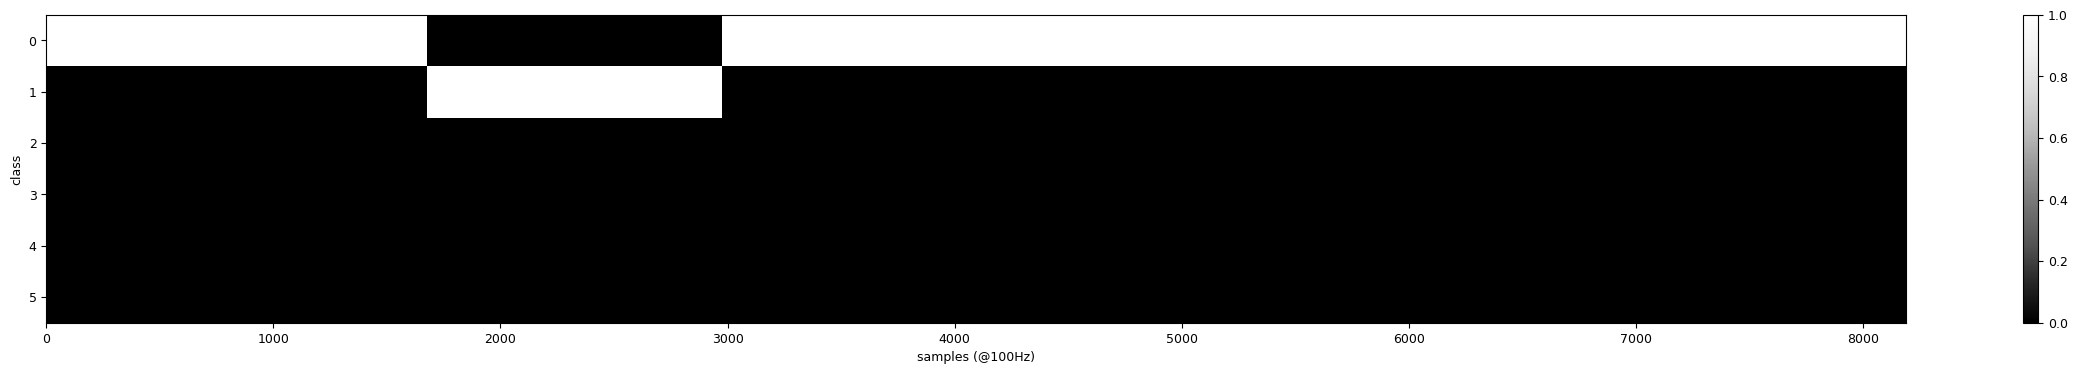

In [5]:
desired_output = example_trace[8:,:]
print(desired_output.shape)
plt.figure(figsize=(30,4))
plt.imshow(desired_output,aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("class")
plt.colorbar()
plt.show()

### Prepare Input:
To pass it through the model, we Fold the 8-channel 1D array to form a 256x256 image:

(8, 8192)
torch.Size([1, 256, 256])


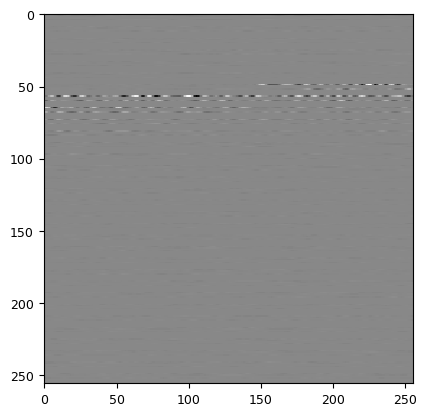

In [6]:
input_signal = example_trace[:8,:]
print(input_signal.shape)
input_tensor = tensor(input_signal)
folded_input = data_utils.fold_X(input_tensor, N=256)
print(folded_input.shape)
plt.imshow(folded_input[0].numpy(), cmap='Greys_r', interpolation='nearest')
plt.show()

Pass the input through the model to obtain 6 predicted 2D masks:

In [7]:
folded_input = folded_input.unsqueeze(0).to(device)
print("Input shape:",folded_input.shape)
output = model(folded_input)
print("Output shape:",output.shape)

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 6, 256, 256])


### We can visualize the desired and predicted masks:

Desired:

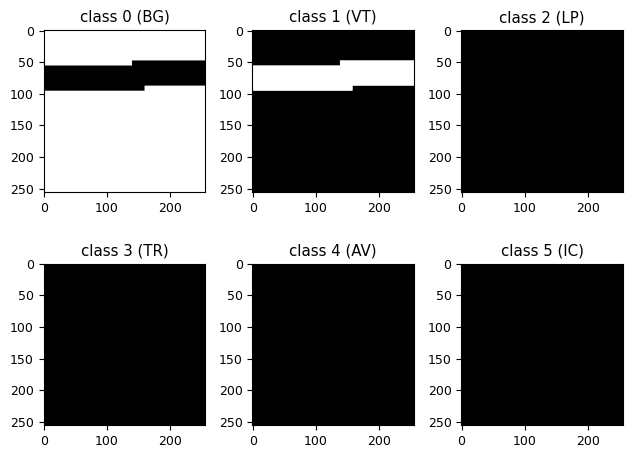

In [19]:
folded_targets = data_utils.fold_y(tensor(desired_output)).numpy()
fig,axes = plt.subplots(2,3)
axes[0,0].imshow(folded_targets[0],cmap='Greys_r')
axes[0,0].set_title('class 0 (BG)')
axes[0,1].imshow(folded_targets[1],cmap='Greys_r')
axes[0,1].set_title('class 1 (VT)')
axes[0,2].imshow(folded_targets[2],cmap='Greys_r')
axes[0,2].set_title('class 2 (LP)')
axes[1,0].imshow(folded_targets[3],cmap='Greys_r')
axes[1,0].set_title('class 3 (TR)')
axes[1,1].imshow(folded_targets[4],cmap='Greys_r')
axes[1,1].set_title('class 4 (AV)')
axes[1,2].imshow(folded_targets[5],cmap='Greys_r')
axes[1,2].set_title('class 5 (IC)')
plt.tight_layout()
plt.show()

Predicted:

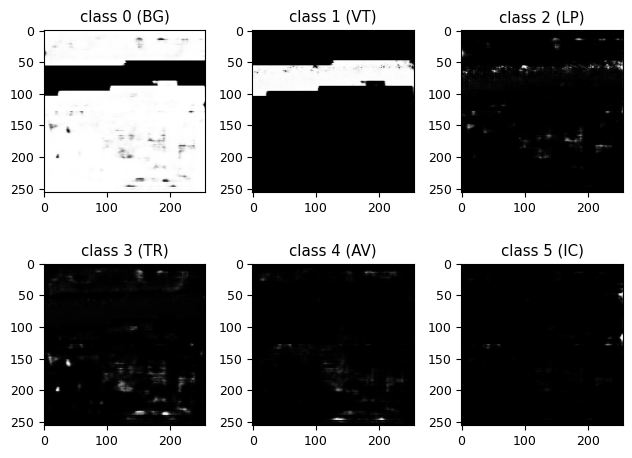

In [8]:
detached_output = output.detach().cpu().numpy()[0]
fig,axes = plt.subplots(2,3)
axes[0,0].imshow(detached_output[0],cmap='Greys_r')
axes[0,0].set_title('class 0 (BG)')
axes[0,1].imshow(detached_output[1],cmap='Greys_r')
axes[0,1].set_title('class 1 (VT)')
axes[0,2].imshow(detached_output[2],cmap='Greys_r')
axes[0,2].set_title('class 2 (LP)')
axes[1,0].imshow(detached_output[3],cmap='Greys_r')
axes[1,0].set_title('class 3 (TR)')
axes[1,1].imshow(detached_output[4],cmap='Greys_r')
axes[1,1].set_title('class 4 (AV)')
axes[1,2].imshow(detached_output[5],cmap='Greys_r')
axes[1,2].set_title('class 5 (IC)')
plt.tight_layout()
plt.show()

To obtain the time segmentation we must unfold the predictions for each class:

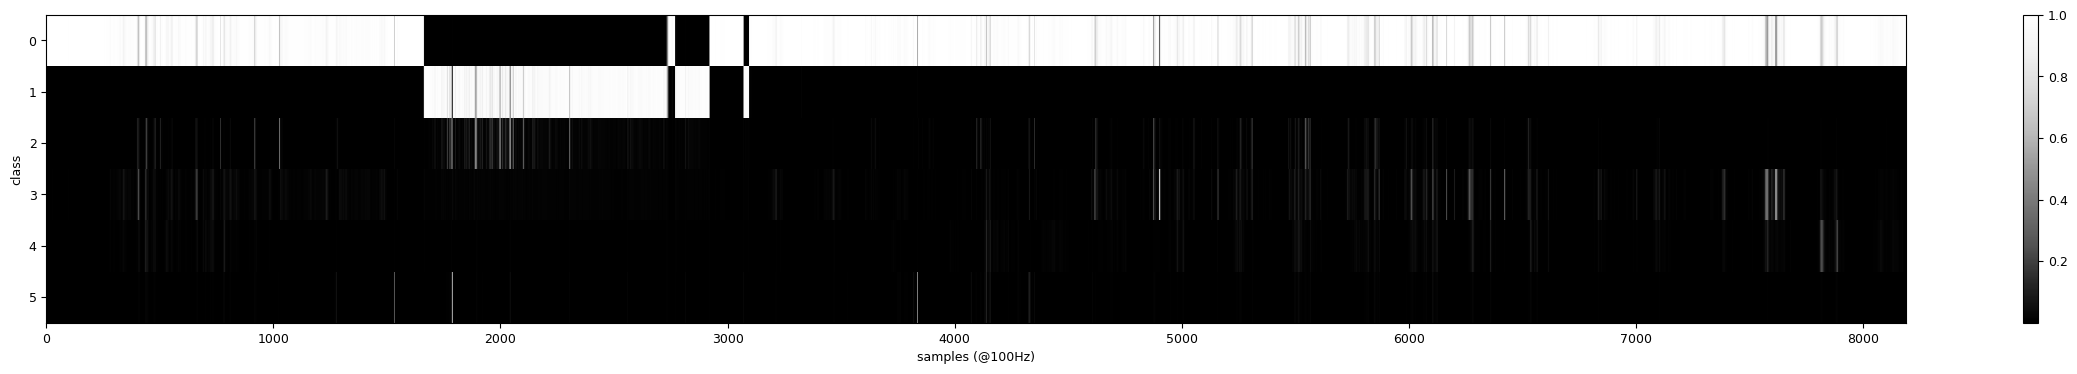

In [9]:
unfolded_predictions = data_utils.unfold_y(output)[0].detach().cpu().numpy()
unfolded_predictions.shape
plt.figure(figsize=(30,4))
plt.imshow(unfolded_predictions,aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("class")
plt.colorbar()
plt.show()

Post-processing is performed to obtain a table with the detected events. Notice that, as the predictions are noisy, the model detects unrealistically short events. We can apply simple heuristics to clean it. The most important is the fact that no event lasts less than 2 seconds (200 samples):

In [10]:
clases_OVDAS= {0.0: "BG", 1.0: "VT", 2.0: "LP", 3.0: "TR", 4.0: "AV", 5.0: "IC"}
detected_events_df = data_utils.post_processing(unfolded_predictions, clases_OVDAS)
detected_events_df

,start,end,length,class_n,class_label
0,1023,1026,3,2,LP
1,1663,2738,1075,1,VT
2,2769,2920,151,1,VT
3,3071,3094,23,1,VT
4,3836,3839,3,5,IC
5,4093,4094,1,1,VT
6,4899,4903,4,3,TR


Post-processing easily results in a clean prediction, which we can show through the plot_segmentation() function:

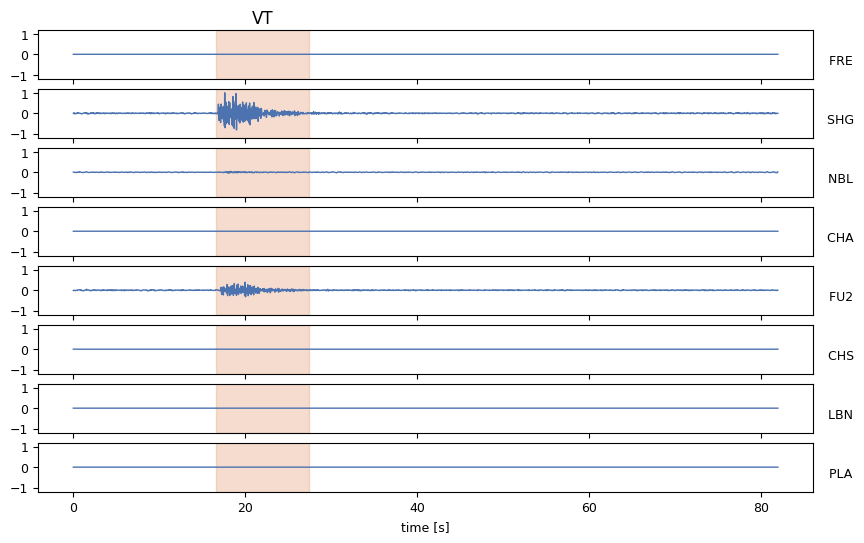

In [11]:
detected_events_df = detected_events_df.query('length>200')
data_utils.plot_segmentation(
    input_signal,
    detected_events_df,
    save_path=None,
    save=False,
    title="",
    num=0,
    dpi=100,
    figsize=(10, 6),
)